In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Deep learning for forecasting is used when:
- The dataset is large (more than 10,000 data points).
- Declination of the SARIMAX model takes a long time to fit.
- The residuals of the statistical model still show some correlation.
- There is more than one seasonal period.

There are three types of models for forecasting:
- Single-step model: Predicts one step into the future for one variable.
- Multistep model: Predicts many steps into the future for one variable.
- Multi-output model: Predicts many variables one or more steps into the future.

In [2]:
df = pd.read_csv('../data/Metro_Interstate_Traffic_Volume.csv')
df['date_time'] = pd.to_datetime(df['date_time'])


In [3]:
df = df.drop_duplicates(subset='date_time', ignore_index=True)
print(df.shape)
date_range = list(pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='H'))
print(len(date_range))
new_df = pd.DataFrame({'date_time': date_range})

(40575, 9)
52551


In [4]:
full_df = pd.merge(new_df, df, how='left', on='date_time')
full_df.isna().sum()

date_time                  0
holiday                11976
temp                   11976
rain_1h                11976
snow_1h                11976
clouds_all             11976
weather_main           11976
weather_description    11976
traffic_volume         11976
dtype: int64

print(len(date_range)) - print(df.shape) = full_df.isna().sum()

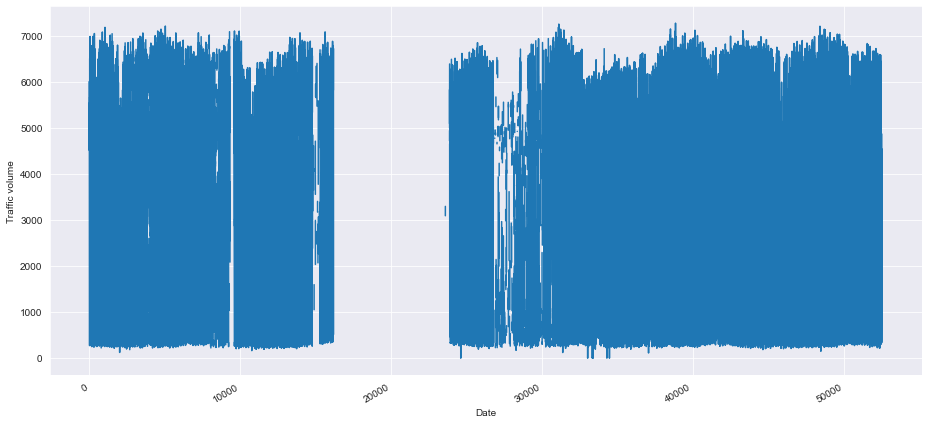

In [5]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(full_df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic volume')

fig.autofmt_xdate()
plt.tight_layout()

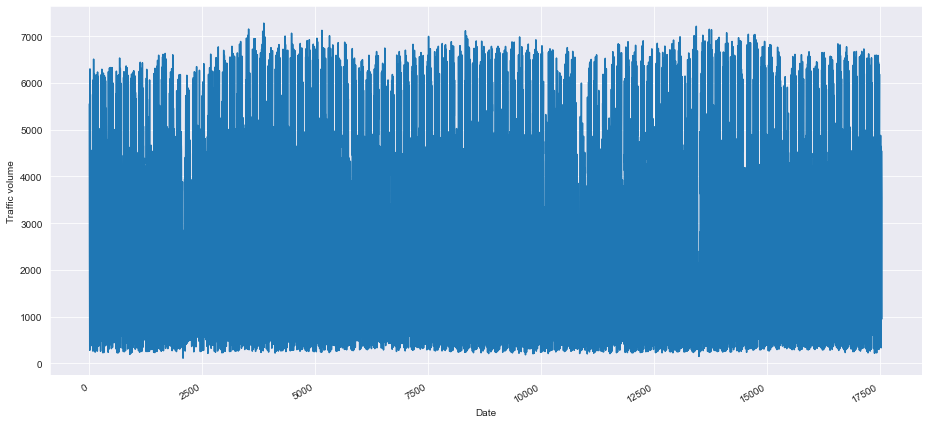

In [6]:
full_df[35000:].isna().sum()
full_df = full_df[35000:].reset_index(drop=True)
full_df = full_df.drop(['holiday', 'weather_main', 'weather_description'], axis=1)
full_df = full_df.fillna(full_df.groupby(full_df.date_time.dt.hour).transform('median'))
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(full_df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic volume')

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import warnings
warnings.filterwarnings('ignore')

2023-12-16 02:18:14.349735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
tf.random.set_seed(42)
np.random.seed(42)
print(tf.__version__)

2.15.0


,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


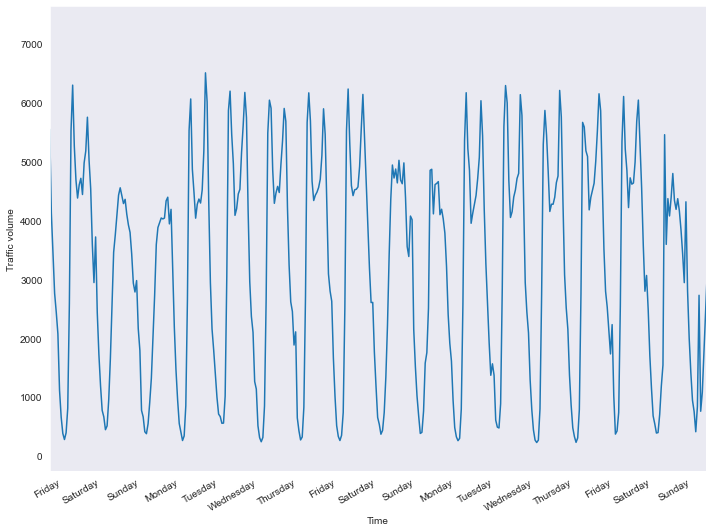

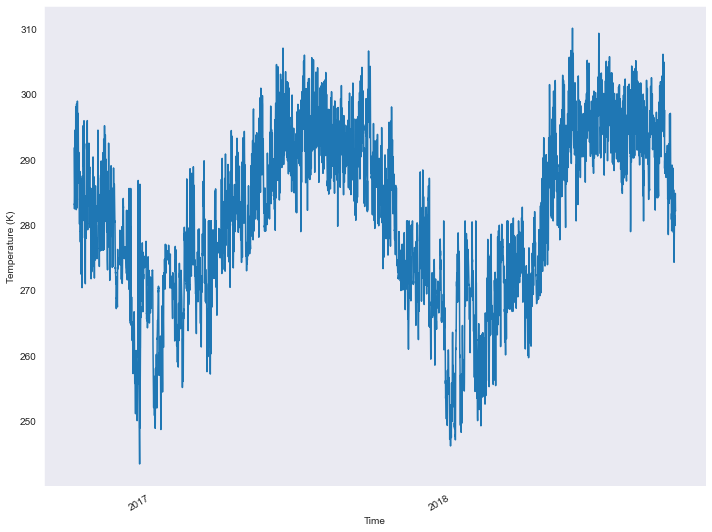

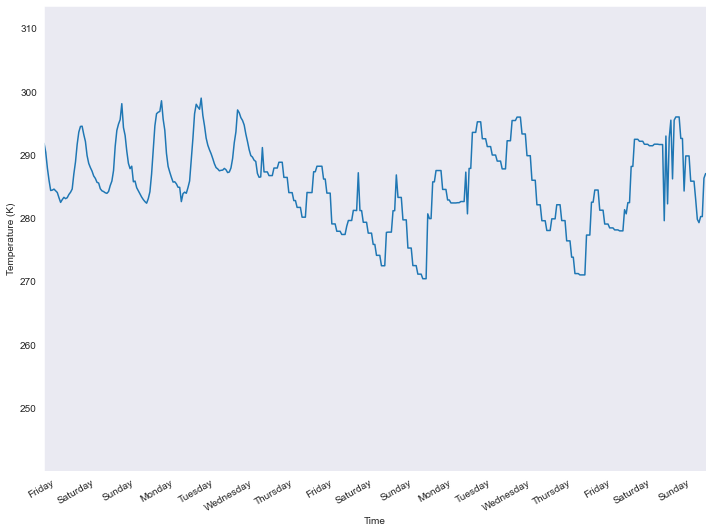

In [9]:
df=full_df.copy()
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()



fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()


fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()


df.head()



first figure we can see daily seasonality (beginning and end of each day is low value) 
weekly also (less traffic on Weekends) 
second figure is temperatures we can see seasons (summer hotter) with daily peaks (night are colder) as we can see on fig 3 (a zoom of figure 2) 


drop unused columns and change dates to seconds  

In [10]:
print(df.describe().transpose())
try:
    df = df.drop(['rain_1h', 'snow_1h'], axis=1)
except KeyError as e: 
    print(f"An error occurred: {e}")
    print("already suppressed")
finally:
    timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

              count       mean       std  min  25%   50%   75%    max
snow_1h     17551.0   0.000000   0.00000  0.0  0.0   0.0   0.0    0.0
clouds_all  17551.0  42.034129  39.06596  0.0  1.0  40.0  90.0  100.0


by changing to seconds, we lost the cyclical nature of time, so let's do some feature engineering

In [11]:
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df = df.drop(['date_time'], axis=1)
df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,-8.660254e-01,0.500000
1,290.36,0,4132.0,-7.071068e-01,0.707107
2,287.86,0,3435.0,-5.000000e-01,0.866025
3,285.91,0,2765.0,-2.588190e-01,0.965926
4,284.31,0,2443.0,-6.611980e-12,1.000000


In [12]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

Before saving the data, we must scale it, so all values are between 0 and 1. This decreases the time required for training deep learning models, and it improves their performance. We’ll use MinMaxScaler from sklearn to scale our data

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [15]:
import sys
sys.path.append('../classes')
from my_window import testClass #type: ignore
my_obj=testClass("pipounette")
print(my_obj.greet())
from my_window import DataWindow,MetaBaselineDataWindow #type: ignore
from baseline import Baseline,MultiStepLastBaseline,MetaBaseline,AverageBaseline,CopyBaseline,LastValueBaseline,RepeatBaseline #type: ignore

Hello, pipounete!


It is now time to go peak at the files classes/my_window then classes/baseline before continuing

Start with Baseline then DataWindow first, I will tell you when to read the rest 

let's create a structure to store our future results

In [26]:
val_performance = {}
performance = {}

So let's create a baseline for multiple scenarii.
The first scenario is predicting a single output with a single value by copying it.
We create and compile baseline_last that will for each data time point copy the last value to use it as prediction

110/110 [==============================] - 0s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831
0.08128399401903152


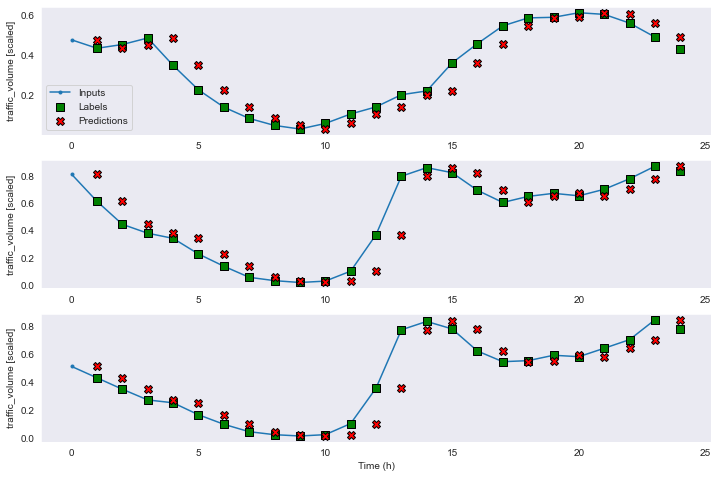

In [36]:
baseline_last = Baseline(label_index=train_df.columns.get_loc('traffic_volume'))
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)
print(performance['Baseline - Last'][1])

 #just to show the prediction on 24 values
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])
wide_window.plot(baseline_last)

time to go check MultiStepLastBaseline in baseline.py

109/109 [==============================] - 0s 2ms/step - loss: 0.1875 - mean_absolute_error: 0.3522
0.3472607433795929


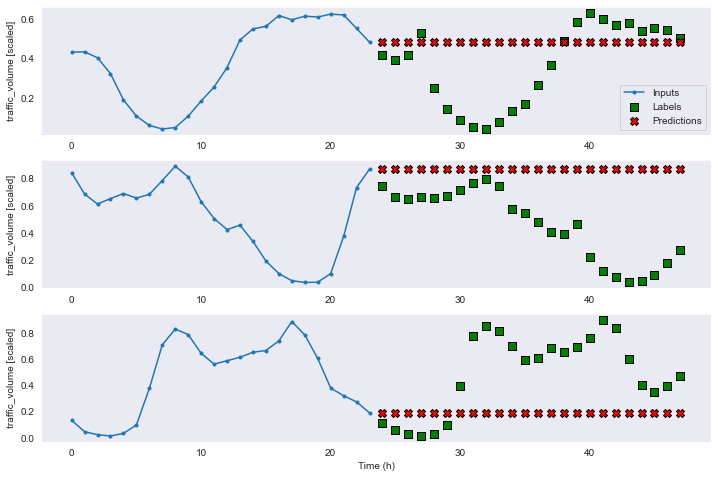

In [37]:
ms_baseline_last = MultiStepLastBaseline(label_index=train_df.columns.get_loc('traffic_volume'))
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])
val_performance['Baseline - Last MultiStep'] = ms_baseline_last.evaluate(multi_window.val)
performance['Baseline - Last MultiStep'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)
print(performance['Baseline - Last MultiStep'][1])
multi_window.plot(ms_baseline_last)

time to check repeat baseline 

109/109 [==============================] - 0s 2ms/step - loss: 0.2065 - mean_absolute_error: 0.3473
0.34127718210220337


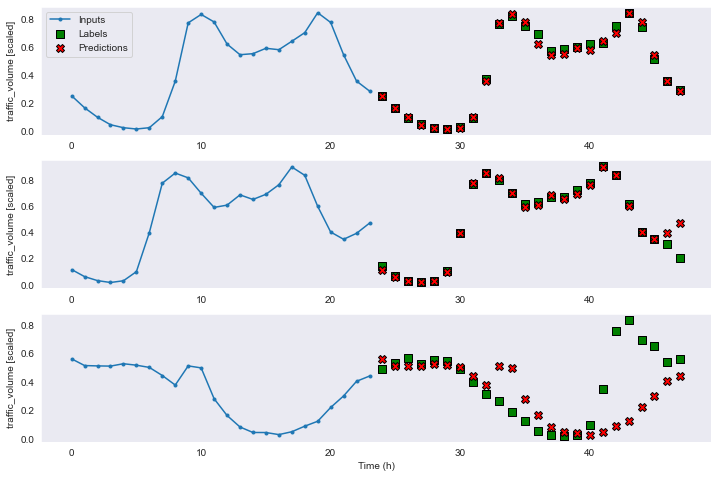

In [38]:
ms_baseline_repeat = RepeatBaseline(label_index=train_df.columns.get_loc('traffic_volume'))
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])
val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)
print(performance['Baseline - Repeat'][1])
multi_window.plot(ms_baseline_repeat)

Now that you get the hang of it, let's explore how we can make our baselines and window more flexible

109/109 [==============================] - 0s 2ms/step - loss: 0.1022 - mean_absolute_error: 0.2668
0.2552611827850342


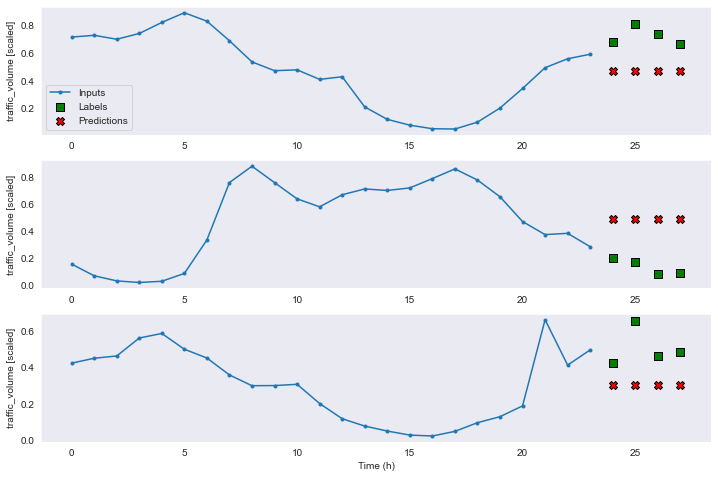

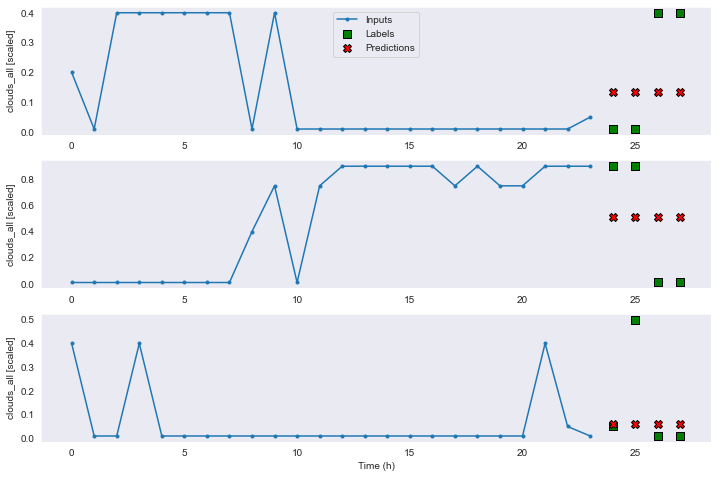

In [44]:
alt_baseline_last = AverageBaseline(label_columns=['traffic_volume','clouds_all'],input_window_size=24,output_prediction_window_size=4)
alt_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
#you can declare like that alternatively
#single_step_window = MetaBaselineDataWindow(input_width=8, label_width=4, shift=4, label_columns=['traffic_volume','clouds_all']) 
single_step_window2 = MetaBaselineDataWindow(model=alt_baseline_last)
val_performance['altBaseline - Avg(24)'] = alt_baseline_last.evaluate(single_step_window2.val)
performance['altBaseline - Avg(24)'] = alt_baseline_last.evaluate(single_step_window2.test, verbose=0)
print(performance['altBaseline - Avg(24)'][1])
single_step_window2.plot_upg()

110/110 [==============================] - 0s 2ms/step - loss: 0.1026 - mean_absolute_error: 0.2078
0.2068469077348709


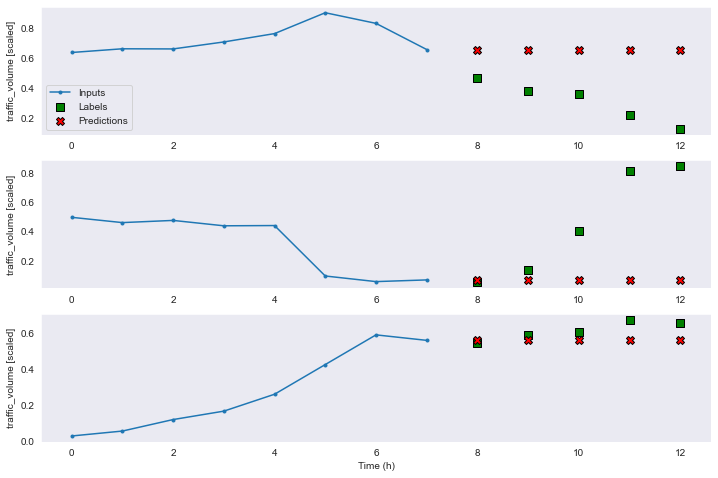

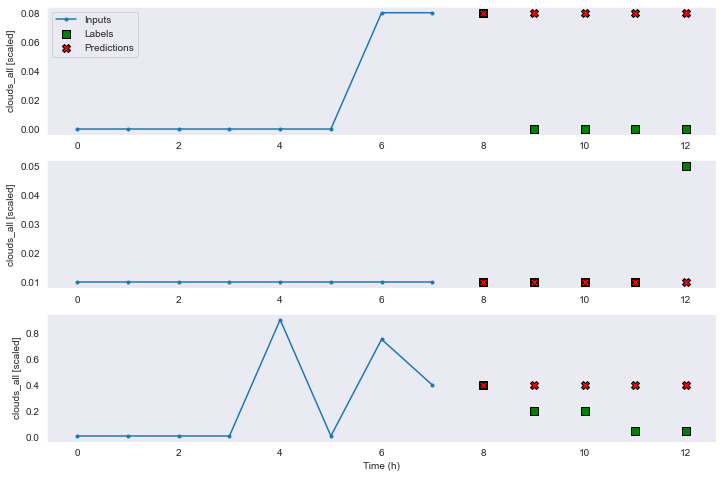

In [45]:

alt_baseline_last = LastValueBaseline(label_columns=['traffic_volume','clouds_all'],input_window_size=8,output_prediction_window_size=5)
alt_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])


single_step_window = MetaBaselineDataWindow(input_width=8, label_width=4, shift=4, label_columns=['traffic_volume','clouds_all']) 
single_step_window2 = MetaBaselineDataWindow(model=alt_baseline_last)
val_performance['altBaseline - Last(4)'] = alt_baseline_last.evaluate(single_step_window2.val)
performance['altBaseline - Last(4)'] = alt_baseline_last.evaluate(single_step_window2.test, verbose=0)
print(performance['altBaseline - Last(4)'][1])
#single_step_window.plot(alt_baseline_last,plot_col='traffic_volume')
single_step_window2.plot_upg()

110/110 [==============================] - 0s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831
0.08128400146961212


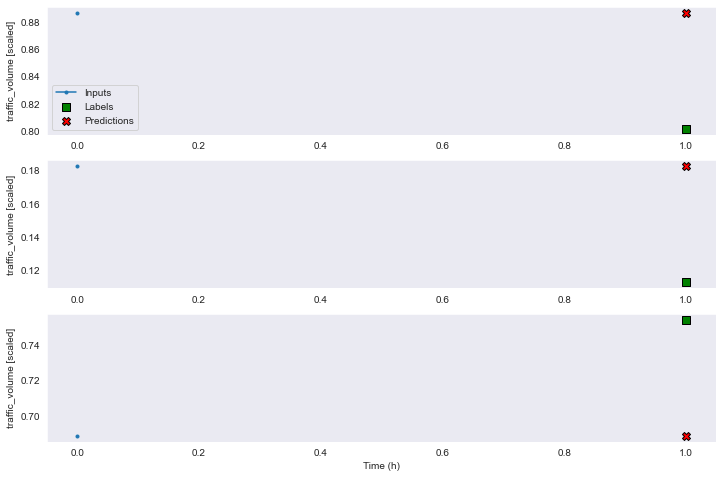

In [48]:

alt_baseline_last = LastValueBaseline(label_columns=['traffic_volume'],input_window_size=1,output_prediction_window_size=1)
alt_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
single_step_window2 = MetaBaselineDataWindow(model=alt_baseline_last)
val_performance['altBaseline - Last(1)'] = alt_baseline_last.evaluate(single_step_window2.val)
performance['altBaseline - Last(1)'] = alt_baseline_last.evaluate(single_step_window2.test, verbose=0)
print(performance['altBaseline - Last(1)'][1])
#single_step_window.plot(alt_baseline_last,plot_col='traffic_volume')
single_step_window2.plot_upg()

109/109 [==============================] - 0s 2ms/step - loss: 0.1250 - mean_absolute_error: 0.2073
0.19614985585212708


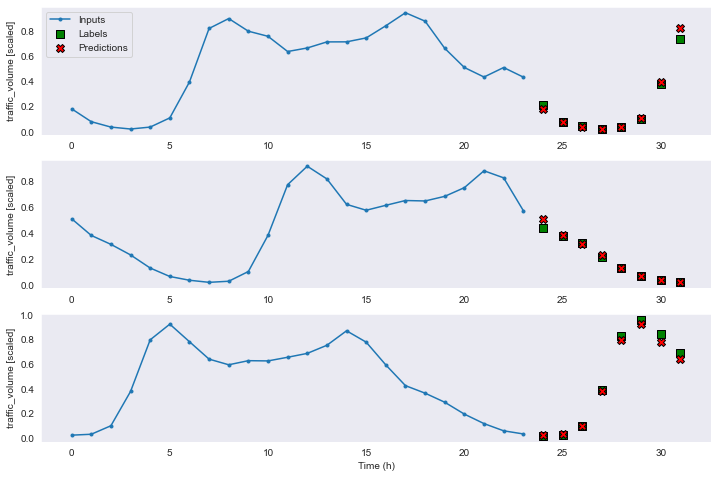

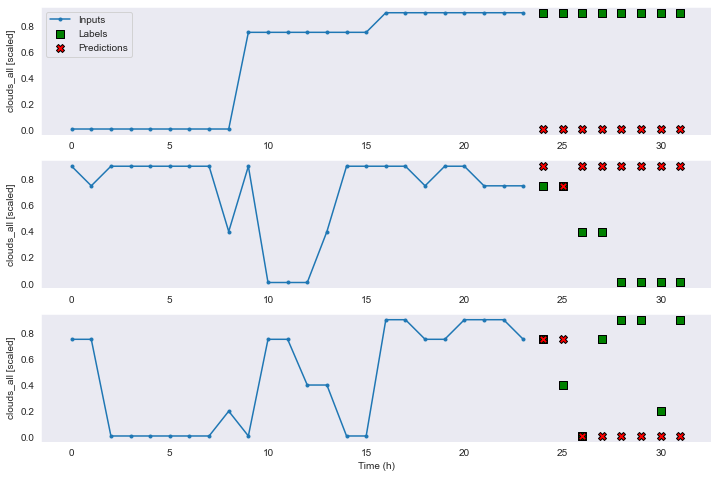

In [53]:
alt_baseline_last = CopyBaseline(label_columns=['traffic_volume','clouds_all'],input_window_size=24,output_prediction_window_size=8)
alt_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
single_step_window2 = MetaBaselineDataWindow(model=alt_baseline_last)
val_performance['altBaseline - Copy'] = alt_baseline_last.evaluate(single_step_window2.val)
performance['altBaseline - Copy'] = alt_baseline_last.evaluate(single_step_window2.test, verbose=0)
print(performance['altBaseline - Copy'][1])
single_step_window2.plot_upg()

[0.013317277655005455, 0.08305126428604126]
[0.18750251829624176, 0.35219016671180725]
[0.20649835467338562, 0.3473060429096222]
[0.11845267564058304, 0.2735348045825958]
[0.10261008888483047, 0.20779438316822052]
[0.12499415129423141, 0.20732656121253967]
[0.10261009633541107, 0.2077943980693817]
[0.10219625383615494, 0.266764372587204]
[0.013317282311618328, 0.08305125683546066]


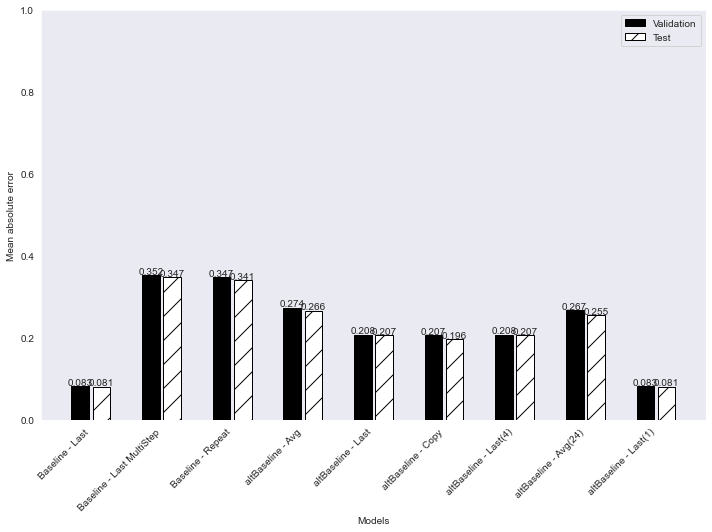

In [67]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

for v in val_performance.values():
    print(v)

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

ax.set_xticks(x)
ax.set_xticklabels(performance.keys(), rotation=45, ha='right')

plt.ylim(0, 1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

our best model is the basic one now it is time to have some fun!